In [3]:
import torch
import train_ae_dft
model = train_ae_dft.Autoencoder()
model.load_state_dict(torch.load("models/ae_dft.pth"))
model.eval()
a=model.to("cuda")

C:\Users\Семья\AppData\Local\Temp\ipykernel_22432\3431962970.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/ae_dft.pth"))


In [4]:
import numpy as np

In [5]:
data = np.load("C:\\Users\\Семья\\Documents\\vibro_analitics\\datasets\\acceleration.npz")

In [6]:
X = data["X"]
y = data["y"]

In [10]:
def encode_ae(data, model, batch_size=128):
    n_batches = data.shape[0] // batch_size + 1
    data.dtype = np.float32
    output = []
    with torch.no_grad():
        for i in range(0, n_batches):
            tensor = torch.from_numpy(data[i * batch_size: (i + 1) * batch_size])
            y = model.encode(tensor.to("cuda")).cpu().detach().numpy()
            output.append(y)
    return np.vstack(output)

In [11]:
_, Y = train_ae_dft.preprocess(X)
X_emb = encode_ae(Y.astype(np.float32), model)

In [26]:
import catboost

In [27]:
model = catboost.CatBoostClassifier(random_state=239, use_best_model=True)

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_full, X_test, y_full, y_test = train_test_split(X_emb, y, test_size=0.2, random_state=239)
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=239)

In [30]:
model.fit(X_train, y_train, eval_set=catboost.Pool(data=X_val, label=y_val))

Learning rate set to 0.109248
0:	learn: 1.5788103	test: 1.5896060	best: 1.5896060 (0)	total: 28.1ms	remaining: 28.1s
1:	learn: 1.4240643	test: 1.4380763	best: 1.4380763 (1)	total: 46.1ms	remaining: 23s
2:	learn: 1.2861963	test: 1.2999625	best: 1.2999625 (2)	total: 62.7ms	remaining: 20.8s
3:	learn: 1.1858535	test: 1.2016285	best: 1.2016285 (3)	total: 80ms	remaining: 19.9s
4:	learn: 1.0946041	test: 1.1122309	best: 1.1122309 (4)	total: 96.5ms	remaining: 19.2s
5:	learn: 1.0255663	test: 1.0451337	best: 1.0451337 (5)	total: 111ms	remaining: 18.4s
6:	learn: 0.9602590	test: 0.9756844	best: 0.9756844 (6)	total: 126ms	remaining: 17.9s
7:	learn: 0.9056938	test: 0.9250051	best: 0.9250051 (7)	total: 142ms	remaining: 17.6s
8:	learn: 0.8555108	test: 0.8756643	best: 0.8756643 (8)	total: 158ms	remaining: 17.4s
9:	learn: 0.8134094	test: 0.8318914	best: 0.8318914 (9)	total: 176ms	remaining: 17.4s
10:	learn: 0.7722491	test: 0.7905750	best: 0.7905750 (10)	total: 193ms	remaining: 17.4s
11:	learn: 0.7391740	

In [31]:
from sklearn.metrics import accuracy_score

In [32]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

In [33]:
accuracy_score(y_train, y_train_pred)

1.0

In [34]:
accuracy_score(y_val, y_val_pred)

0.94

In [35]:
accuracy_score(y_test, y_test_pred)

0.9555160142348754

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [38]:
accuracy = accuracy_score(y_test, y_test_pred)

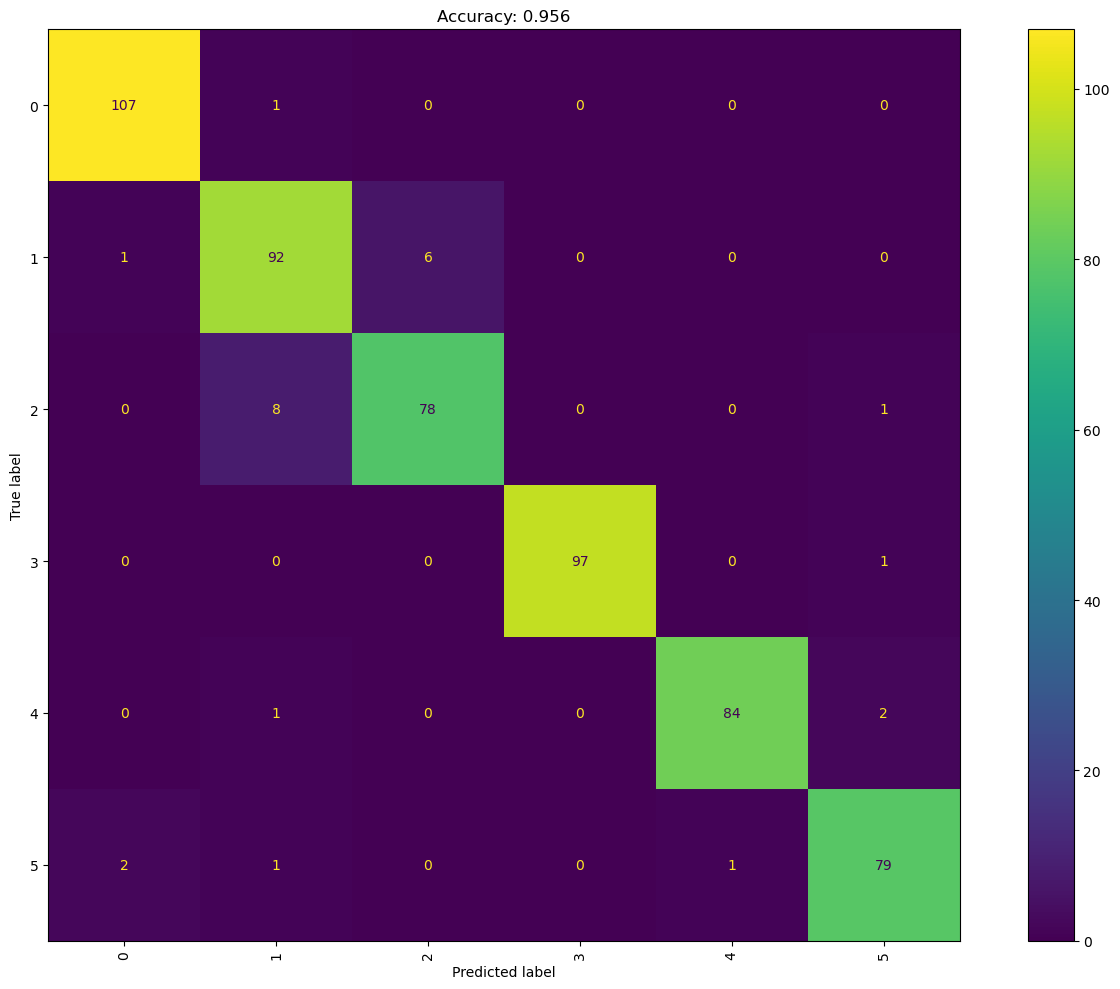

In [39]:
fig, ax = plt.subplots(1, figsize=(14, 10))
labels = list(sorted(set(y_test)))
cm = confusion_matrix(y_test, y_test_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(ax=ax, xticks_rotation="vertical")
plt.title("Accuracy: {:.3f}".format(accuracy))
plt.tight_layout()
plt.show()

In [40]:
from sklearn.manifold import TSNE

In [42]:
import numpy as np

In [45]:
labels_dict = {l: i for i, l in enumerate(labels)}
clr = np.linspace(0, 1, len(labels))
colors = [clr[labels_dict[l]] for l in y_test]

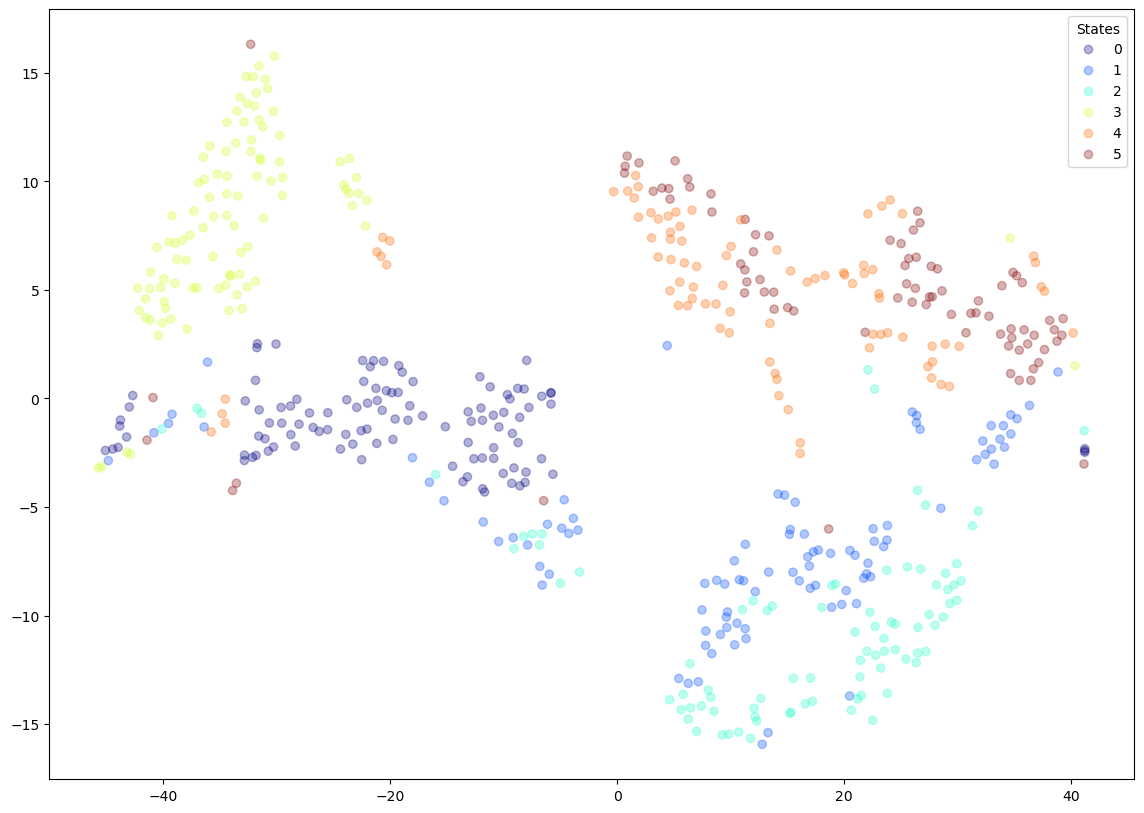

In [46]:
tsne = TSNE(n_components=2, init="pca").fit(X_train)
X_test_tsne = tsne.fit_transform(X_test)
fig, ax = plt.subplots(1, figsize=(14, 10))
scatter = ax.scatter(
        X_test_tsne[:, 0], X_test_tsne[:, 1], c=colors, alpha=0.3, cmap="jet"
)
handles, _ = scatter.legend_elements()
ax.legend(handles, labels, title="States", loc="upper right")
plt.show()